In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from corpy.get_data.get_data import data_download

data_download()

Downloading...
From: https://drive.google.com/u/0/uc?id=11ozVs6zByFjs9viD3VIIP6qKFgjZwv9E&export=download
To: /home/roger/code/xkeeja/corpy-assessment/screws.zip
100%|██████████| 195M/195M [00:09<00:00, 20.2MB/s] 


Unzipping file...
Data successfully unzipped to data/archive.
Deleting zip file...
Deleted zip file.


In [35]:
from corpy.ml_logic.data import load_data

batch_size = 32
img_size = 128

ds_train = load_data(batch_size, img_size, 'train')
ds_test = load_data(batch_size, img_size, 'test')

Found 250 files belonging to 1 classes.
Found 180 files belonging to 1 classes.


In [36]:
from corpy.ml_logic.model import create_encoder, create_decoder

latent_dim = 128

encoder, shape = create_encoder(img_size, latent_dim)
decoder = create_decoder(shape, latent_dim)

In [37]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 batch_normalization_18 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        18464     
                                                                 
 batch_normalization_19 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 32)        9248

In [38]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_7 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape_3 (Reshape)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 32, 32, 64)       18496     
 Transpose)                                                      
                                                                 
 batch_normalization_21 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_transpose_13 (Conv2D  (None, 64, 64, 32)       1846

In [39]:
import tensorflow.keras as keras
from corpy.ml_logic.model import AutoEncoder

rop = keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.2,
    patience=10,
    min_lr=0.00001,
    cooldown=100,
    verbose=1)

ae = AutoEncoder(encoder, decoder)
ae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [40]:
ae.build(input_shape=(None,128,128,3))
ae.load_weights('trained/ae_mse_weights.h5')

<AxesSubplot: >

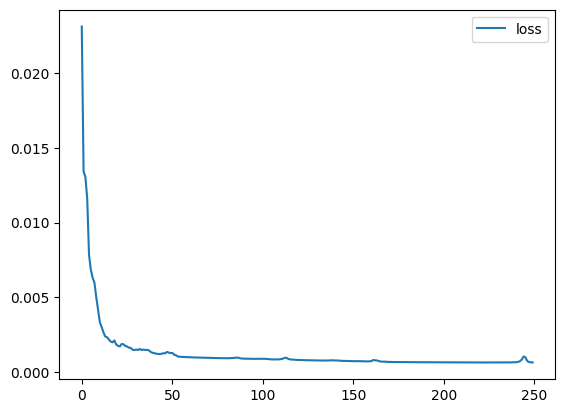

In [41]:
import pandas as pd

mse_history = pd.read_csv('trained/ae_mse_history.csv')
mse_history.loc[:, ['loss']].plot()

[INFO] number of test images: 180
[INFO] mse threshold: 0.0013959501753561198
[INFO] 18 anomalies found


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


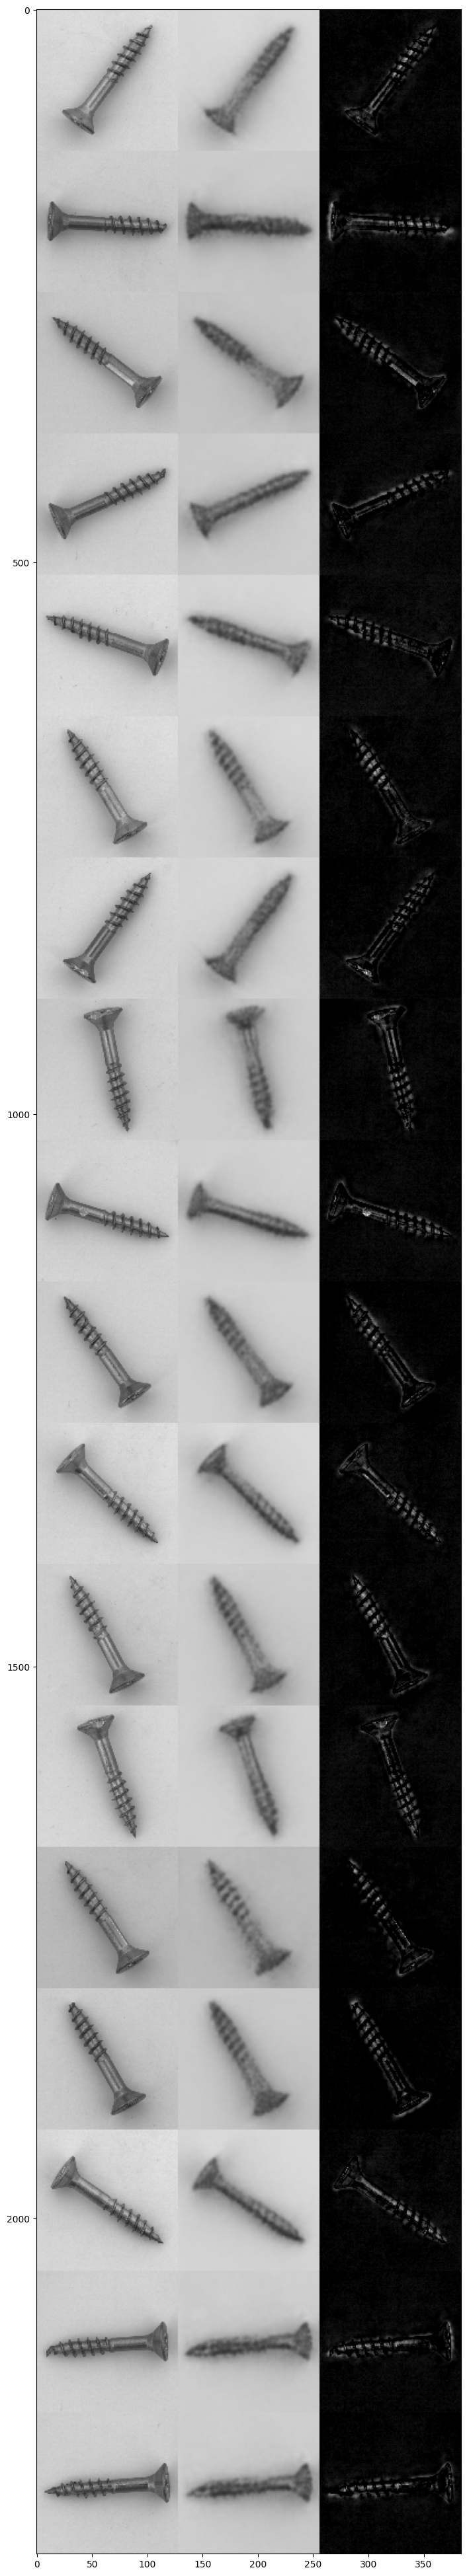

In [42]:
import matplotlib.pyplot as plt
import numpy as np

images = []
recon = []
for batch in range(len(list(ds_test))):
	input = list(ds_test)[batch]
	output = ae(input)
	images.extend(input)
	recon.extend(list(output))
errors = []

print(f"[INFO] number of test images: {len(images)}")

# loop over all original images and their corresponding
# reconstructions
for (image, rec) in zip(images, recon):
	# compute the mean squared error between the ground-truth image
	# and the reconstructed image, then add it to our list of errors
	mse = np.mean((image - rec) ** 2)
	errors.append(mse)

# compute the q-th quantile of the errors which serves as our
# threshold to identify anomalies -- any data point that our model
# reconstructed with > threshold error will be marked as an outlier
thresh = np.quantile(errors, 0.90)
idxs = np.where(np.array(errors) >= thresh)[0]
print(f"[INFO] mse threshold: {thresh}")
print(f"[INFO] {len(idxs)} anomalies found")

# initialize the outputs array
outputs = None

# loop over the indexes of images with a high mean squared error term
for i in idxs:
	# grab the original image and reconstructed image
	original = images[i]
	rec = recon[i]
	diff = (original - rec) * 2
	

    # stack the original and reconstructed image side-by-side
	output = np.hstack([original, rec, diff])

    # if the outputs array is empty, initialize it as the current
	# side-by-side image display
	if outputs is None:
		outputs = output

    # otherwise, vertically stack the outputs
	else:
		outputs = np.vstack([outputs, output])

# show the output visualization
plt.figure(figsize=(12, 50))
plt.imshow(outputs)